# Image Captioning with Conditioned LSTM Generators
## Chengming He

In this project, I will be building an image captioning system using deep learning techniques. The goal of the project is for me to create a system that can generate natural language descriptions for images. I will use an off-the-shelf image encoder to create matrices of image representations and an LSTM language generator to produce captions for those images.

I will start by reading and preprocessing the image captions, and then I will write a generator function that returns one training instance (input/output sequence pair) at a time. After that, I will train the LSTM language generator on the caption data and write a decoder function for it.

Next, I will add the image input to write an LSTM caption generator, and finally, I will implement beam search for the image caption generator. 

By the end of this project, I will have a working image captioning system that can generate captions for a given image.

### Import required packages


In [1]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline


from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from google.colab import drive

### About the data

I will use the flickr8k data set, described here in  detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results


The Flickr8k dataset is a collection of 8,000 images with corresponding captions, collected from the photo-sharing website Flickr. Each image has five captions written by different human annotators, providing a rich and diverse set of descriptions for each image. The dataset was created for the purpose of image captioning research and has been widely used as a benchmark for evaluating the performance of image captioning models. It is a popular dataset due to its relatively small size and easy accessibility, making it a good starting point for researchers and developers interested in image captioning.

In [9]:
my_data_dir="deep_learning_project/data"

### Mounting GDrive to access the files from Colab

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. Image Encodings 

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists. 

In [13]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [14]:
train_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.trainImages.txt')
dev_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.devImages.txt')
test_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.testImages.txt')

We can see how many images are there.

In [ ]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [ ]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [57]:
IMG_PATH = "/content/gdrive/My Drive/deep_learning_project/data/Flickr8k_Dataset"

We can use PIL to open the image and matplotlib to display it. 

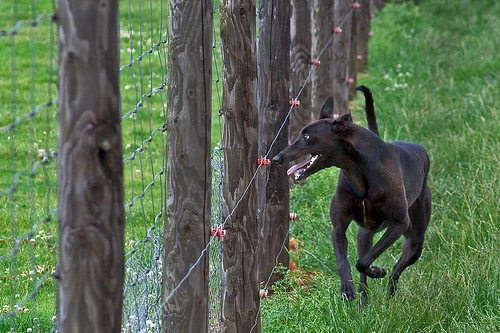

In [ ]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

I am going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model: 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

I will use PIL to resize the image and then divide every value by 255. 

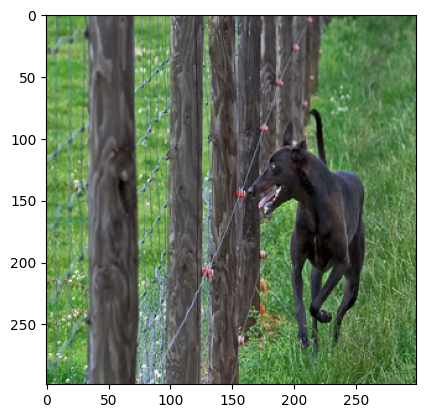

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [ ]:
new_image.shape

(299, 299, 3)

In [54]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                      

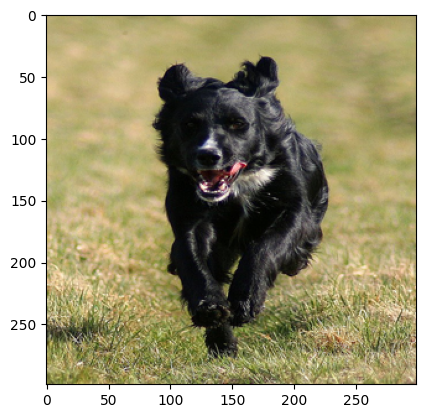

In [ ]:
plt.imshow(get_image(dev_list[25]))

Next, I load the pre-trained Inception model. 

In [ ]:
img_model = InceptionV3(weights='imagenet') 

96112376/96112376 [==============================] - 5s 0us/step


In [ ]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

I will remove the last 2 layers which are softmax predictions and only keep the embeddings.

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model I will use.

Try the encoder. 

In [ ]:
encoded_image = img_encoder.predict(np.array([new_image]))
print(encoded_image.shape)
encoded_image

1/1 [==============================] - 7s 7s/step
(1, 2048)


array([[0.63806653, 0.48873085, 0.05526268, ..., 0.64255726, 0.29595238,
        0.49004412]], dtype=float32)

 We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, dev, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) I will read in the images lazily using a generator. 
The following generator function returns one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

In [53]:
def img_generator(img_list):
    for img in img_list:
      image = PIL.Image.open(os.path.join(IMG_PATH, img))
      image = np.asarray(image.resize((299,299))) / 255.0  
      image = np.reshape(image,(1,299,299,3))
      yield image

Now we can encode all images .

In [ ]:
enc_train = img_encoder.predict(img_generator(train_list), steps=len(train_list), verbose=1)

6000/6000 [==============================] - 4025s 671ms/step


In [ ]:
enc_train[11]

array([0.2681862 , 1.0321662 , 0.58516276, ..., 1.2316732 , 0.1796934 ,
       0.22405232], dtype=float32)

In [ ]:
enc_dev = img_encoder.predict(img_generator(dev_list), steps=len(dev_list), verbose=1)

1000/1000 [==============================] - 665s 665ms/step


In [ ]:
enc_test = img_encoder.predict(img_generator(test_list), steps=len(test_list), verbose=1)

1000/1000 [==============================] - 662s 662ms/step


Save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:
np.save("gdrive/My Drive/deep_learning_project/data/outputs/encoded_images_train.npy", enc_train)
np.save("gdrive/My Drive/deep_learning_project/data/outputs/encoded_images_dev.npy", enc_dev)
np.save("gdrive/My Drive/deep_learning_project/data/outputs/encoded_images_test.npy", enc_test)

In [6]:
enc_train = np.load("gdrive/My Drive/deep_learning_project/data/outputs/encoded_images_train.npy")
enc_dev = np.load("gdrive/My Drive/deep_learning_project/data/outputs/encoded_images_dev.npy")
enc_test = np.load("gdrive/My Drive/deep_learning_project/data/outputs/encoded_images_test.npy")

## 2. Text (Caption) Data Preparation

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

The following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. 
The keys of the dictionary are image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so I just split them at white spaces and convert each token to lower case. I then pad each caption with a START token on the left and an END token on the right. 

In [7]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)    
    file = open(filename,'r')
    lines = file.readlines()
    for l in lines:
      l = l.strip().split()
      pic_name = l[0][:-2]
      description = l[1:]
      description = [word.lower() for word in description]
      description.insert(0,'<START>')
      description.append('<END>')
      image_descriptions[pic_name].append(description)
    return image_descriptions

In [10]:
descriptions = read_image_descriptions("gdrive/My Drive/"+my_data_dir+"/Flickr8k.token.txt")

In [15]:
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


### Creating Word Indices

Next, we need to create a lookup table from the training data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. The codes below create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.   

In [16]:
word_to_id = {}
train_words = set()
for file in train_list:
  for line in descriptions[file]:
    train_words = train_words.union(set(line))
train_words = sorted(train_words)
for i,word in enumerate(train_words):
  word_to_id[word] = i

In [19]:
id_to_word = {}
for key in word_to_id:
  id_to_word[word_to_id[key]] = key

In [17]:
print(word_to_id['dog']) # should print an integer

1985


In [20]:
print(id_to_word[1985]) # should print a token

dog


In [21]:
## index 0 is not a word and is used for padding
print(id_to_word[0])

!


## 3.Basic Decoder Model 

First, I will just train a model for text generation without conditioning the generator on the image input. 


The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. I'm going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

To train the model, I will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`


| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



I'm using the Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

I'm using an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [27]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2312100   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dense (Dense)               (None, 7707)              7899675   
                                                                 
Total params: 13,541,823
Trainable params: 13,541,823
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data


The function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.


In [28]:
def text_training_generator(batch_size=128):
  while True:
  ## initialization of x_train and y_train to be two empty lists
    x_train = []
    y_train = []
    for k,file in enumerate(train_list):
      for l,line in enumerate(descriptions[file]):
        code = [word_to_id[word] for word in line]
        for i in range(len(code)-1):
          sub_sentence = code[0:i+1]
          for j in range(i+1,MAX_LEN):
            sub_sentence.append(0)
          label = [0]*vocab_size
          label[code[i+1]]=1
          x_train.append(sub_sentence)
          y_train.append(label)
          if (len(x_train) == batch_size) | ((k == len(train_list)-1)&(l == len(descriptions[file])-1)&(i == len(code)-2)):
            #if batch_size to reached or the epoch is done then yield the batch and reset x_train and y_train
            yield np.array(x_train),np.array(y_train)
            x_train = []
            y_train = []

### Training the Model

I used the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.


In [29]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

**The model is trained on GCP and saved.**

In [30]:
##reload the model to show that a desired accuracy is achieved
basic_model = load_model('gdrive/My Drive/deep_learning_project/models/basic_model')
# basic_model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=1)

### Greedy Decoder

Here, I implemented a simple decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [34]:
def decoder():
    sentence = ['<START>']
    pred = None
    while (pred != '<END>') & (len(sentence)<MAX_LEN):
      ##convert string to integers
      input_sentence = [word_to_id[word] for word in sentence]
      ##append 0 to the list to MAX_LEN
      for i in range(len(input_sentence),MAX_LEN):
        input_sentence.append(0)
      ##reshape the input to (1,MAX_LEN)
      input_sentence = np.array(input_sentence).reshape((1,MAX_LEN))
      ##retrieve the output string and append to the sentence
      pred = id_to_word[np.argmax(basic_model.predict(input_sentence,verbose=0))]
      sentence.append(pred)
    return sentence

In [36]:
print(decoder());

['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'is', 'running', 'through', 'a', 'grassy', 'area', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

I modified the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. 

In [40]:
def sample_decoder():
    sentence = ['<START>']
    pred = None
    while (pred != '<END>') & (len(sentence)<MAX_LEN):
      input_sentence = [word_to_id[word] for word in sentence]
      for i in range(len(input_sentence),MAX_LEN):
        input_sentence.append(0)
      input_sentence = np.array(input_sentence).reshape((1,MAX_LEN))
      probability = basic_model.predict(input_sentence,verbose=0)[0].astype('float64')
      probability = probability/sum(probability)
      pred = id_to_word[np.argmax(np.random.multinomial(1,probability))]        
      sentence.append(pred)
    return sentence

Below generates 10 sentences...

In [41]:
for i in range(10): 
    print(sample_decoder())

['<START>', 'a', 'small', 'and', 'brown', 'dog', 'holding', 'a', 'bottle', 'while', 'he', 'stands', 'in', 'the', 'surf', '.', '<END>']
['<START>', 'riding', 'a', 'man', 'in', 'a', 'white', 'coat', 'suit', 'up', 'in', 'a', 'bedroom', 'beach', 'jacket', 'on', 'a', 'snowy', 'road', 'after', 'women', 'is', 'in', 'a', 'brick', 'area', '.', '<END>']
['<START>', 'three', 'young', 'men', 'and', 'an', 'adult', 'pose', 'for', 'the', 'camera', 'with', 'sunglasses', '.', '<END>']
['<START>', 'two', 'children', 'background', 'at', 'the', 'headfirst', 'beside', 'a', 'many', 'sprayed', 'bubbles', 'staring', 'to', 'snowy', 'setting', 'is', 'blowing', 'investigates', '.', '<END>']
['<START>', 'three', 'men', 'in', 'face', 'during', 'the', 'snowboarder', 'among', 'smile', 'in', 'front', 'of', 'a', 'competition', '.', '<END>']
['<START>', 'a', 'little', 'boy', 'in', 'black', 'and', 'sand', 'poles', 'runs', 'past', 'a', 'mountainside', '.', '<END>']
['<START>', 'young', 'girl', 'crowd', 'into', 'a', 'tabl

## 3. Conditioning on the Image

In this section, I will extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

I will project the 2048-dimensional image encoding to a 300-dimensional hidden layer, then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [42]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 300)          614700      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense_1[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

In [43]:
enc_train = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy")
enc_dev = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy")

In [44]:
def training_generator(batch_size=128):
    while True:
      imamge_inputs = []
      text_input = []
      next_word = []
      for k,file in enumerate(train_list):
        for l,description in enumerate(descriptions[file]):
          code = [word_to_id[word] for word in description]
          for i in range(len(code)-1):
            sub_sentence = code[0:i+1]
            for j in range(i+1,MAX_LEN):
              sub_sentence.append(0)
            label = [0]*vocab_size
            label[code[i+1]]=1
            text_input.append(sub_sentence)
            next_word.append(label)
            imamge_inputs.append(enc_train[k])
            if (len(text_input) == batch_size) | ((k==len(train_list)-1)&(l==len(descriptions[file])-1)&(i == len(code)-2)):
              yield ([np.array(imamge_inputs),np.array(text_input)],np.array(next_word))
              text_input = []
              next_word = []
              imamge_inputs = []


In [45]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

**The model is trained on GCP and saved.**

In [48]:
#reload the model to show the desired accuracy is achieved
full_model = load_model('gdrive/My Drive/deep_learning_project/models/full_model')
# full_model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=1)

In [ ]:
# model.save_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

In [ ]:
# model.load_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

Now we are ready to actually generate image captions using the trained model. 

In [59]:
def image_decoder(enc_image): 
    sentence = ['<START>']
    pred = None
    while (pred != '<END>') & (len(sentence)<40):
      input_sentence = [word_to_id[word] for word in sentence]
      for i in range(len(input_sentence),MAX_LEN):
        input_sentence.append(0)
      input_sentence = np.array(input_sentence).reshape((1,MAX_LEN))
      probability = full_model.predict([enc_image.reshape((1,2048)),input_sentence],verbose=0)[0].astype('float64')
      pred = id_to_word[np.argmax(probability)]        
      sentence.append(pred)
    return sentence

As a sanity check, now we are able to reproduce (approximately) captions for the training images. 

'<START> a white dog is swimming through water . <END>'

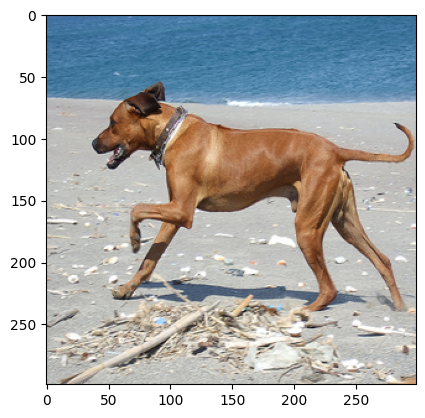

In [61]:
plt.imshow(get_image(train_list[3]))
" ".join(image_decoder(enc_train[3]))

'<START> a white dog is jumping in the air after a red frisbee . <END>'

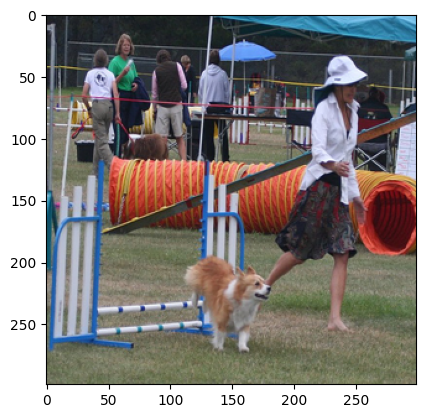

In [62]:
plt.imshow(get_image(dev_list[2]))
" ".join(image_decoder(enc_dev[2]))

## 4.Beam Search Decoder 

In this section, I modified the simple greedy decoder for the caption generator to use beam search. 
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I used a list of `(probability, sequence)` tuples here. After each time-step, prune the list to include only the n most probable sequences. 

Then, for each sequence,I compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, I can create a new list of n*n candidates. 

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated. 

The occurence of the `"<END>"` tag  can not be used to terminate generation, because the tag may occur in different positions for different entries in the beam. 

Once `MAX_LEN` has been reached, return the most likely sequence out of the current n. 

In [66]:
def img_beam_decoder(n, image_enc):
    #initailization
    sequences = [(1,['<START>'])]*n
    #sentence = ['<START>']
    for i in range(0,MAX_LEN-1):
      seq_cache = []
      for j in range(n):
        input_sentence = [word_to_id[word] for word in sequences[j][1]]
        for k in range(len(input_sentence),MAX_LEN):
          input_sentence.append(0)
        input_sentence = np.array(input_sentence).reshape((1,MAX_LEN))
        probability = full_model.predict([image_enc.reshape((1,2048)),input_sentence],verbose=0)[0].astype('float64')
        ##choose n most possible
        index = np.argsort(probability)
        next_word = [(probability[index[-(i+1)]],id_to_word[index[-(i+1)]]) for i in range(n)]
        for l in range(n):
          seq = sequences[j][1]+[next_word[l][1]]
          prob = sequences[j][0]*next_word[l][0]
          seq_cache.append((prob,seq))
        if i == 0:
        #if i is 0, no need to loop through n
          break
      
      #prune seq_cache
      seq_cache_sorted = sorted(seq_cache,key=lambda tup:tup[0])
      sequences = seq_cache_sorted[-n:]
    
    sequences = sorted(sequences,key=lambda tup:tup[0])

    ##trim to <END>，the last tuple has the largest probalility
    output = []    
    for word in sequences[-1][1]:
      output.append(word)
      if word == '<END>':
        break
    return output

<START> a bunch of children in an orange ball . <END>


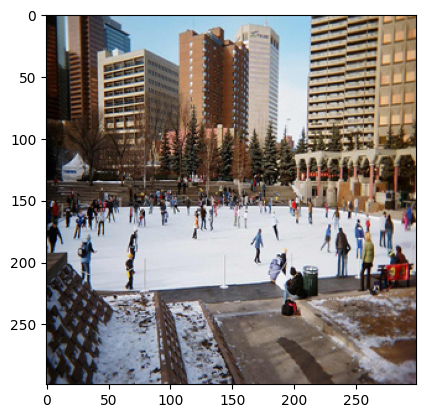

In [67]:
print(" ".join(img_beam_decoder(3, enc_dev[6])))
plt.imshow(get_image(dev_list[6]))

## Conclusion and Comparison

Greedy output        : <START> a woman in a white coat and hat sits next to a red wall . <END>
Beam search(3) output: <START> a man and woman sit together holding a white and black dog on a leash . <END>
Beam search(5) output: <START> a man and woman sit together holding hands , outside a naked figure . <END>


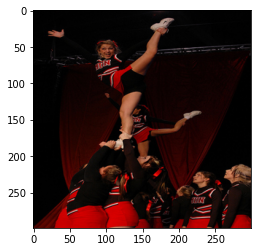

In [ ]:
dev_index = 67
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))

Greedy output        : <START> a man in a white shirt and jeans is standing in a large rock face . <END>
Beam search(3) output: <START> a man in a white shirt and jeans is standing on top of a rock . <END>
Beam search(5) output: <START> a man in a red shirt climbs a rock wall . <END>


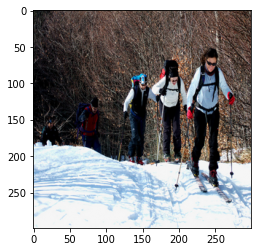

In [ ]:
dev_index = 82
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))

Greedy output        : <START> a brown dog swimming for a tennis ball . <END>
Beam search(3) output: <START> a brown dog swimming for a ball outside . <END>
Beam search(5) output: <START> a white dog swimming in a pool <END>


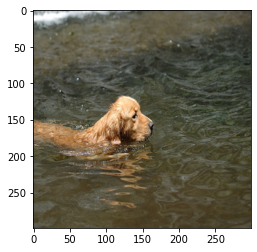

In [ ]:
dev_index = 86
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))

Greedy output        : <START> a black dog is standing on his head . <END>
Beam search(3) output: <START> a brown dog leaps in the air to catch a frisbee . <END>
Beam search(5) output: <START> a brown dog runs with a tennis ball . <END>


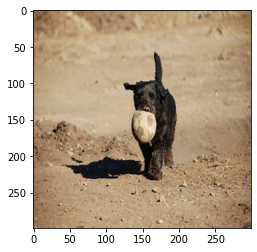

In [ ]:
dev_index = 183
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))

Greedy output        : <START> a white dog with brown ears standing in grass . <END>
Beam search(3) output: <START> a brown and white dog leaps in the air to catch a red ball . <END>
Beam search(5) output: <START> a white dog with brown spots is chewing on a stick . <END>


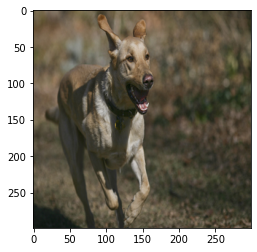

In [ ]:
dev_index = 653
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))

Greedy output        : <START> a white dog runs across a rocky field . <END>
Beam search(3) output: <START> a brown dog is running through a grassy area . <END>
Beam search(5) output: <START> a white dog leaps in the air while another dog is holding him . <END>


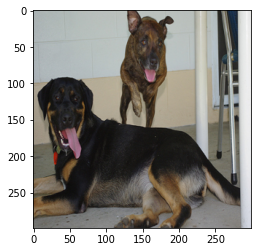

In [ ]:
dev_index = 144
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))

Greedy output        : <START> a man and a woman sit on a bench outside in the two fish . <END>
Beam search(3) output: <START> a man and woman sit together looking at another children look on . <END>
Beam search(5) output: <START> a woman and two children crossing a bridge in a park . <END>


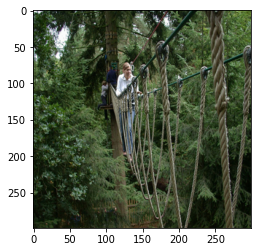

In [ ]:
dev_index = 600
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))

Greedy output        : <START> a child in a red shirt is reaching out to catch a ball . <END>
Beam search(3) output: <START> a little girl in a red shirt holds a red ball out the side of the ocean . <END>
Beam search(5) output: <START> a little girl in a red shirt holds a red ball out his tongue out . <END>


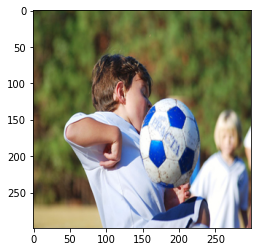

In [ ]:
dev_index = 76
greedy = image_decoder(enc_dev[dev_index])
beam3 = img_beam_decoder(3, enc_dev[dev_index])
beam5 = img_beam_decoder(5, enc_dev[dev_index])
plt.imshow(get_image(dev_list[dev_index]))
print('Greedy output        : {}'.format(' '.join(greedy)))
print('Beam search(3) output: {}'.format(' '.join(beam3)))
print('Beam search(5) output: {}'.format(' '.join(beam5)))